In [25]:
# %gui qt6

# # Qt6 stuff
# from PyQt6.QtWidgets import QApplication
# from PyQt6 import QtWidgets
# from PyQt6 import QtGui
# from PyQt6 import QtCore
# from PyQt6.QtCore import pyqtSignal

# Plotting stuff
import pyqtgraph as pg
import matplotlib.pyplot as plt
import cmasher as cmr
from astropy.visualization import ZScaleInterval, imshow_norm

# Science stuff
import numpy as np
import pandas as pd
from spectres import spectres

# Astropy stuff
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.units.quantity import Quantity
from astropy.io.ascii import read as ascii_read

# zHunter stuff
from zhunter import DIRS
from zhunter import io
from zhunter.misc import set_up_linked_vb
from zhunter.colors import get_gradient
from zhunter.spectroscopic_system import SpecSystemModel, SpecSystem

# Astropalmerio stuff
import astropalmerio.spectra as sp

# General stuff
import logging
import sys
from pathlib import Path
from itertools import cycle

In [2]:
# Logging
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

In [3]:
plt.style.use('paper')
plt.style.use('kraken')
colors = cmr.take_cmap_colors('Spectral', 10, cmap_range=(0.0, 1), return_fmt='hex')

In [4]:
fname_2D = Path('/Users/palmerio/Code_projects/zHunter/dev/data/test_input_files/XSHOOTER_esoreflex_2D.fits.gz')
fname_2D = Path('/Users/palmerio/Science_projects/Reduced_data/GRB230325A/xsh_scired_slit_nod_SCI_SLIT_FLUX_MERGE2D_UVB_UVB_1x2_100k.fits')

wvlg, spat, flux, unc, header = io.read_fits_2D_spectrum(fname_2D)
wvlg = wvlg.value
spat = spat.value
flux = flux.value
unc = unc.value

2023-04-12 14:42:11,134 INFO [zhunter.io] Attempting to read file: /Users/palmerio/Science_projects/Reduced_data/GRB230325A/xsh_scired_slit_nod_SCI_SLIT_FLUX_MERGE2D_UVB_UVB_1x2_100k.fits
2023-04-12 14:42:11,173 WARNING [astropy] UnitsWarning: 'erg/s/cm2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard
2023-04-12 14:42:11,220 DEBUG [zhunter.io] Using the FITS CD matrix.
2023-04-12 14:42:11,221 DEBUG [zhunter.io] PIX=1.0 VAL=-10.5799999237061 DELT=0.159999847412109
2023-04-12 14:42:11,222 DEBUG [zhunter.io] Using the FITS CD matrix.
2023-04-12 14:42:11,223 DEBUG [zhunter.io] PIX=1.0 VAL=298.92 DELT=0.0199999999999818


In [5]:
def get_observing_conditions(header):
    try:
        fwhm_mean = np.nanmean([header['ESO TEL AMBI FWHM START'],header['ESO TEL AMBI FWHM END']])
        airmass_mean = np.nanmean([header['ESO TEL AIRM START'],header['ESO TEL AIRM END']])
        seeing_mean = fwhm_mean * (airmass_mean)**(3/5)  # From Jonatan Selsing's post-processing scripts
    except KeyError:
        log.error("Could not get seeing and airmass from header.")
    return fwhm_mean, airmass_mean, seeing_mean

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_4578/439036751.py:3: RuntimeWarning: invalid value encountered in divide
  im, norm = imshow_norm(flux/unc, ax=ax, aspect='auto', origin='lower',


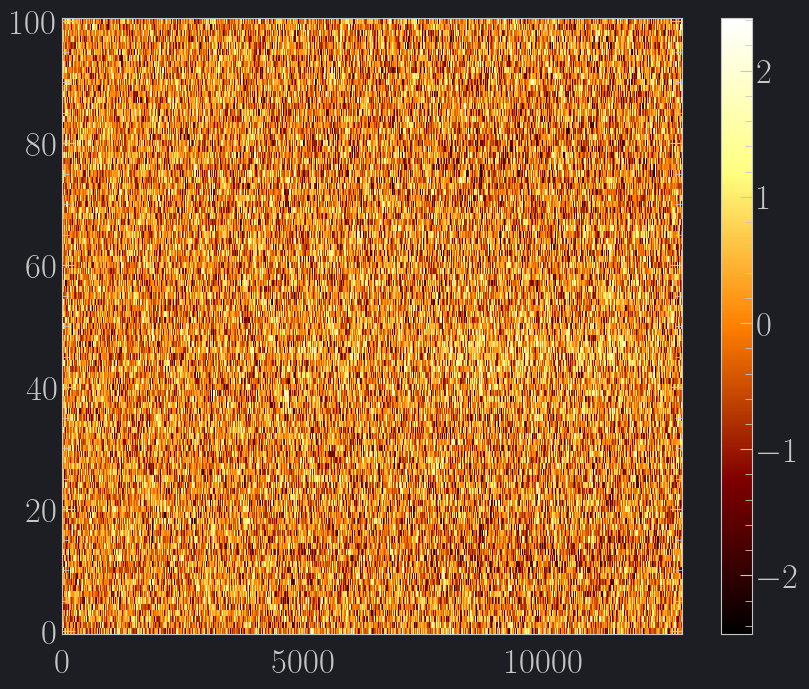

In [6]:
fig, ax = plt.subplots()
# Plot 2D
im, norm = imshow_norm(flux/unc, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')
plt.colorbar(im)

plt.show()

In [18]:
SNR = flux/unc
SNR_1D = SNR.flatten()

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_4578/214648054.py:1: RuntimeWarning: invalid value encountered in divide
  SNR = flux/unc


In [28]:
def show_unit_gauss(ax, x=None, sigmas=5, **kwargs):
    if x is None:
        x = np.linspace(-sigmas,sigmas,101)
    ax.plot(x, sp.gaussian_fct(x, 0, 1), **kwargs)
    return

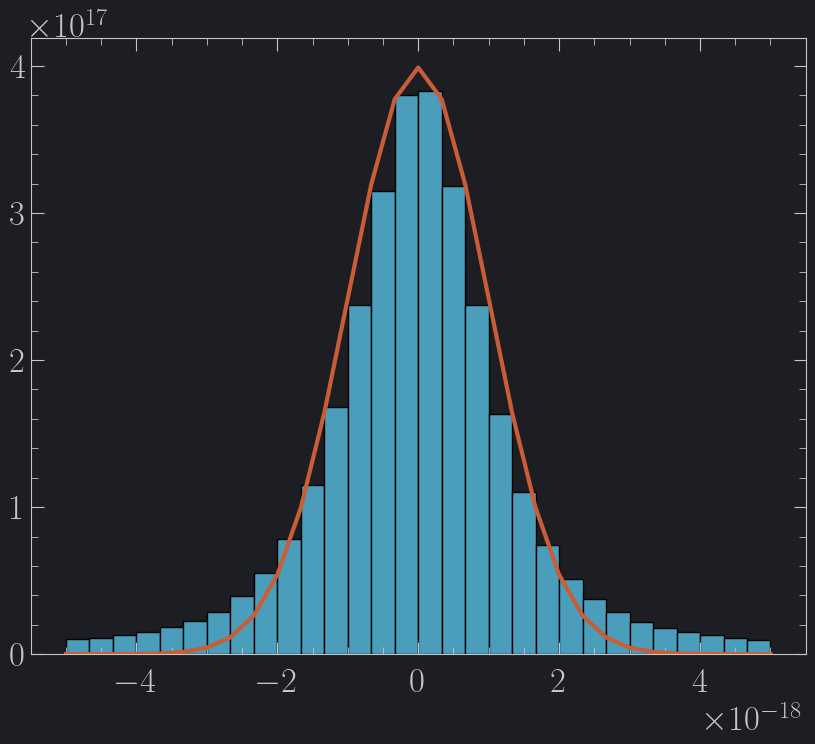

In [36]:
fig, ax = plt.subplots()
bins = np.linspace(-5,5,31)*1e-18
ax.hist(flux.flatten(),
        bins=bins,
        density=True,
       )


ax.plot(bins, sp.gaussian_fct(bins, 0, 1e-18))

# show_unit_gauss(ax)

plt.show()

## Bin 2D flux array in wavelength dimension

In [7]:
n_bins = 10
pixel_bin_edges = np.linspace(0, flux.shape[1]-1, n_bins+1, dtype=int)
SNR_binned = np.zeros((flux.shape[0], n_bins))
wvlg_bins_med = np.zeros(n_bins)
for i in range(0,n_bins):
    pix_beg, pix_end = pixel_bin_edges[i], pixel_bin_edges[i+1]
    wvlg_bins_med[i] = 0.5*(wvlg[pix_beg]+wvlg[pix_end])
    log.info(f"Calculating median SNR between {wvlg[pix_beg]:.2f} and {wvlg[pix_end]:.2f} nm ({pix_beg} - {pix_end} px)")
    # Use SNR here because its better when using the find_peaks function of scipy
    # Also use the median to avoid contamination from very strong pixels
    SNR_binned[:,i] = np.nanmedian(flux[:,pix_beg:pix_end]/unc[:,pix_beg:pix_end],axis=1)
    

2023-04-12 14:42:20,074 INFO [__main__] Calculating median SNR between 298.92 and 324.62 nm (0 - 1285 px)
2023-04-12 14:42:20,085 INFO [__main__] Calculating median SNR between 324.62 and 350.32 nm (1285 - 2570 px)
2023-04-12 14:42:20,094 INFO [__main__] Calculating median SNR between 350.32 and 376.02 nm (2570 - 3855 px)
2023-04-12 14:42:20,103 INFO [__main__] Calculating median SNR between 376.02 and 401.74 nm (3855 - 5141 px)
2023-04-12 14:42:20,111 INFO [__main__] Calculating median SNR between 401.74 and 427.44 nm (5141 - 6426 px)
2023-04-12 14:42:20,120 INFO [__main__] Calculating median SNR between 427.44 and 453.14 nm (6426 - 7711 px)
2023-04-12 14:42:20,129 INFO [__main__] Calculating median SNR between 453.14 and 478.86 nm (7711 - 8997 px)
2023-04-12 14:42:20,138 INFO [__main__] Calculating median SNR between 478.86 and 504.56 nm (8997 - 10282 px)
2023-04-12 14:42:20,147 INFO [__main__] Calculating median SNR between 504.56 and 530.26 nm (10282 - 11567 px)
2023-04-12 14:42:20

/var/folders/r1/qchx86rn3tx643ytrjxf6pmm0000gn/T/ipykernel_4578/1579722815.py:11: RuntimeWarning: invalid value encountered in divide
  SNR_binned[:,i] = np.nanmedian(flux[:,pix_beg:pix_end]/unc[:,pix_beg:pix_end],axis=1)


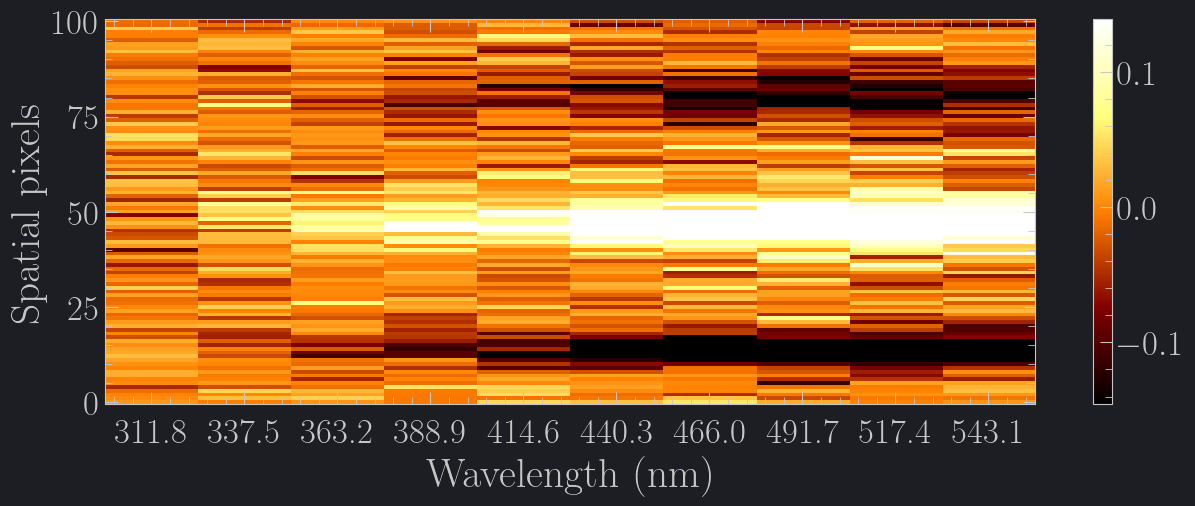

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(SNR_binned, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       cmap='afmhot',
                       interpolation='none')

plt.colorbar(im)
ax = plt.gca()
ax.set_xticks(np.arange(len(wvlg_bins_med)))
ax.set_xticklabels([f"{w:.1f}" for w in wvlg_bins_med])
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial pixels')

plt.show()

In [62]:
fig.savefig('/Users/palmerio/Desktop/GRB230325A_wvlg_binned.png', bbox_inches='tight')

## Show the collapsed spatial histogram for each binned flux

In [10]:
from astropy.modeling.models import Gaussian1D
from specutils.fitting import fit_lines
from specutils import Spectrum1D
from astropy.modeling import models, fitting
from astropalmerio.spectra import fwhm_to_sigma

In [11]:
fwhm, airmass, seeing = get_observing_conditions(header)
seeing_px = seeing/header['CDELT2']
print(f"Observing conditions: fwhm = {fwhm:.3f}\", airmass = {airmass:.3f}, seeing = {seeing:.3f}\", {seeing_px:.3f} pix ")
spat_range = spat.max() - spat.min()
spat_pixels = np.arange(len(spat))

Observing conditions: fwhm = 0.930", airmass = 1.373, seeing = 1.125", 7.029 pix 


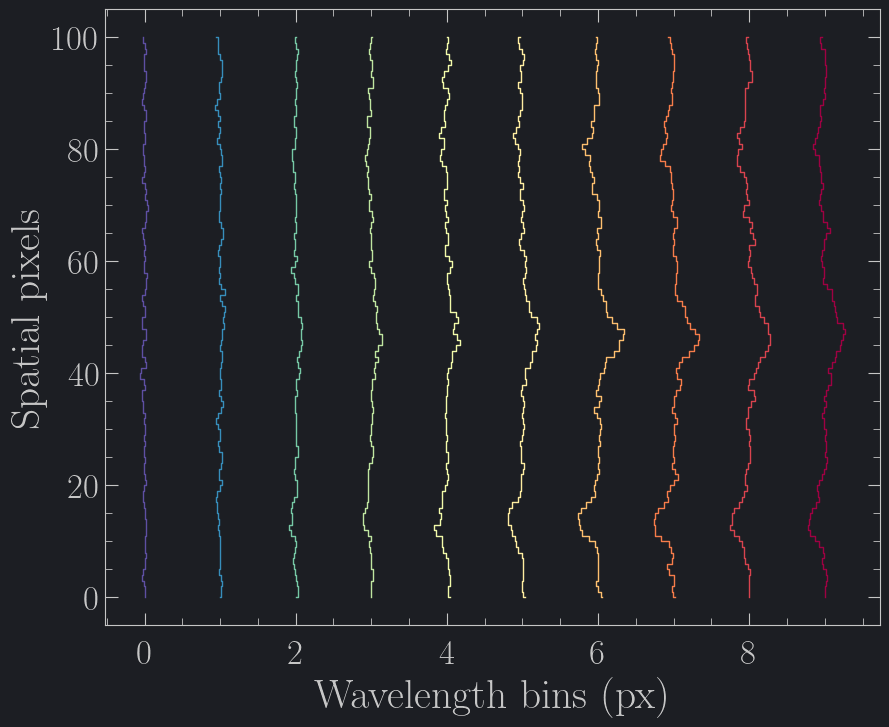

In [12]:
fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')

for i in range(n_bins):
    ax.plot(
        i+SNR_binned[:,i],
        spat_pixels,
        color=colors[i],
        drawstyle='steps-mid',
        lw=1,
    )

ax.set_xlabel('Wavelength bins (px)')
ax.set_ylabel('Spatial pixels')
plt.show()

## Try to find the center and width of the trace in each collapsed spectrum

We try 2 different methods here

### 1) Using `find_peaks` of scipy

In [13]:
from scipy.signal import find_peaks
from numpy.polynomial import Polynomial

In [14]:
# Search for peaks
# Do everything in pixel space

spat_collapsed_spec = {}
rebinned_px = []
centers_px = []
widths_px = []

for i in range(n_bins):
    sl = {}
    log.info(f"Searching for peaks in bin {wvlg[pixel_bin_edges[i]]:.2f} to {wvlg[pixel_bin_edges[i+1]]:.2f} nm "
             f"({pixel_bin_edges[i]} - {pixel_bin_edges[i+1]} px)"
            )
    pks, props = find_peaks(SNR_binned[:,i], height=1, width=[int(seeing_px), len(spat)/2])
    if len(pks) > 1:
        log.warning(f"More than one peak was found for wavelength bin {wvlg[pixel_bin_edges[i]]:.2f} to {wvlg[pixel_bin_edges[i+1]]:.2f} nm "
                    f"({pixel_bin_edges[i]} - {pixel_bin_edges[i+1]} px)")
    sl['flux'] = SNR_binned[:,i]
    sl['peaks'] = pks
    sl['peak_props'] = props
    if len(pks) != 0:
        rebinned_px.append(i)
        centers_px.append(sl['peaks'])
        sigma = fwhm_to_sigma(sl['peak_props']['widths'])
        widths_px.append(sigma)
    spat_collapsed_spec[f'{i}'] = sl
    

# Turn everything into arrays
rebinned_px = np.array(rebinned_px)
centers_px = np.array(centers_px).flatten()
widths_px = np.array(widths_px).flatten()


2023-04-12 14:42:55,940 INFO [__main__] Searching for peaks in bin 298.92 to 324.62 nm (0 - 1285 px)
2023-04-12 14:42:55,941 INFO [__main__] Searching for peaks in bin 324.62 to 350.32 nm (1285 - 2570 px)
2023-04-12 14:42:55,943 INFO [__main__] Searching for peaks in bin 350.32 to 376.02 nm (2570 - 3855 px)
2023-04-12 14:42:55,943 INFO [__main__] Searching for peaks in bin 376.02 to 401.74 nm (3855 - 5141 px)
2023-04-12 14:42:55,944 INFO [__main__] Searching for peaks in bin 401.74 to 427.44 nm (5141 - 6426 px)
2023-04-12 14:42:55,945 INFO [__main__] Searching for peaks in bin 427.44 to 453.14 nm (6426 - 7711 px)
2023-04-12 14:42:55,946 INFO [__main__] Searching for peaks in bin 453.14 to 478.86 nm (7711 - 8997 px)
2023-04-12 14:42:55,947 INFO [__main__] Searching for peaks in bin 478.86 to 504.56 nm (8997 - 10282 px)
2023-04-12 14:42:55,947 INFO [__main__] Searching for peaks in bin 504.56 to 530.26 nm (10282 - 11567 px)
2023-04-12 14:42:55,948 INFO [__main__] Searching for peaks in b

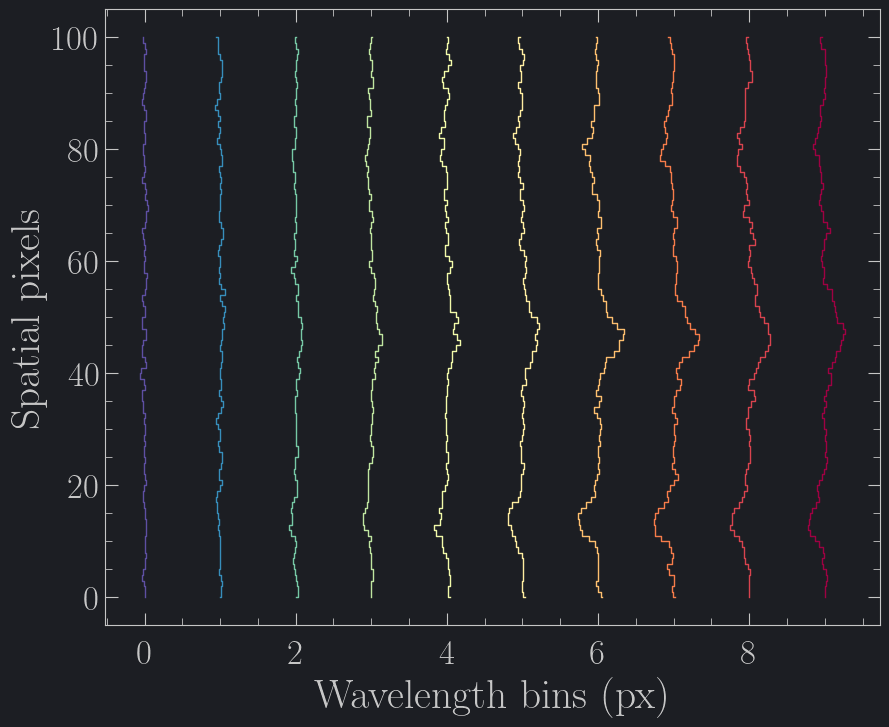

In [15]:
# Plot the peaks

fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')

for i in range(n_bins):
    # Plot collapsed spectrum
    ax.plot(
        i+SNR_binned[:,i],
        spat_pixels,
        color=colors[i],
        drawstyle='steps-mid',
        lw=1,
    )

    sl = spat_collapsed_spec[f'{i}']
    if len(sl['peaks']) != 0:
        sigma = fwhm_to_sigma(sl['peak_props']['widths'])
        # Plot the peak and width that was found
        ax.plot(
            [i,i,i],
            [sl['peaks']-3*sigma, sl['peaks'], sl['peaks']+3*sigma],
            marker='o',
            markersize=3,
            lw=1,
            color=colors[i],
        )

ax.set_xlabel('Wavelength bins (px)')
ax.set_ylabel('Spatial pixels')
plt.show()

In [36]:
### Fit them as a function of pixels
polyn_deg = 2

center_fit = Polynomial.fit(
    x=rebinned_px,
    y=centers_px,
    deg=polyn_deg,
)
width_fit = Polynomial.fit(
    x=rebinned_px,
    y=widths_px,
    deg=polyn_deg,
)

ValueError: Coefficient array is empty

NameError: name 'center_fit' is not defined

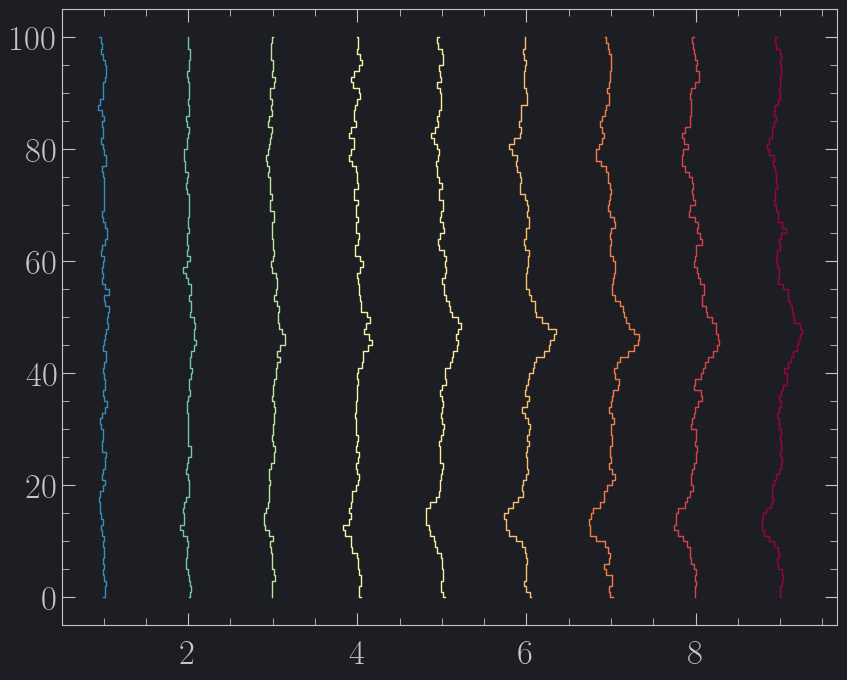

In [37]:
### Show the fit
# Do everything in pixel space

fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')


for i in range(n_bins):
    # Plot collapsed spectrum
    ax.plot(
        i+SNR_binned[:,i],
        spat_pixels,
        color=colors[i],
        drawstyle='steps-mid',
        lw=1,
    )

    sl = spat_collapsed_spec[f'{i}']
    if len(sl['peaks']) != 0:
        sigma = fwhm_to_sigma(sl['peak_props']['widths'])
        # Plot the peak and width that was found
        ax.plot(
            [i,i,i],
            [sl['peaks']-3*sigma, sl['peaks'], sl['peaks']+3*sigma],
            marker='o',
            markersize=3,
            lw=1,
            color=colors[i],
        )

x = np.linspace(0,n_bins,n_bins)
ax.plot(
    x,
    center_fit(x),
    lw=2,
    ls='--',
    color='C12'
)
ax.plot(
    x,
    center_fit(x)+3*width_fit(x),
    lw=2,
    ls=':',
    color='C12'
)
ax.plot(
    x,
    center_fit(x)-3*width_fit(x),
    lw=2,
    ls=':',
    color='C12'
)

ax.set_xlabel('Wavelength bins (px)')
ax.set_ylabel('Spatial pixels')
plt.show()

### 2) Fit each collapsed spectrum with a gaussian

In [38]:
# Fitting

fit_rebinned_px = []
fit_centers_px = []
fit_widths_px = []

for i in range(n_bins): 
    sl = spat_collapsed_spec[f'{i}']
    flux_to_fit = SNR_binned[:,i]
    if all(np.isnan(flux_to_fit)):
        g = Gaussian1D(
            mean=len(spat)/2,
            stddev=len(spat)/4,
            amplitude=0)
    else:
        g_init = Gaussian1D(
            mean=len(spat)/2,
            stddev=np.ceil(fwhm_to_sigma(seeing_px)),
            amplitude=np.max(flux_to_fit),
            bounds={
                'mean':(0, len(spat)),
                'stddev':(np.floor(fwhm_to_sigma(seeing_px)), len(spat)/2),
                'amplitude':(0,np.inf),
            }
        )
        x = spat_pixels
        y = sl['flux']
        fit_g = fitting.DogBoxLSQFitter()
        g = fit_g(g_init, x, y)
    
    sl['fit_model'] = g
    fit_rebinned_px.append(i)
    fit_centers_px.append(g.mean.value)
    fit_widths_px.append(g.stddev.value)
    
fit_rebinned_px = np.array(fit_rebinned_px)
fit_centers_px = np.array(fit_centers_px)
fit_widths_px = np.array(fit_widths_px)


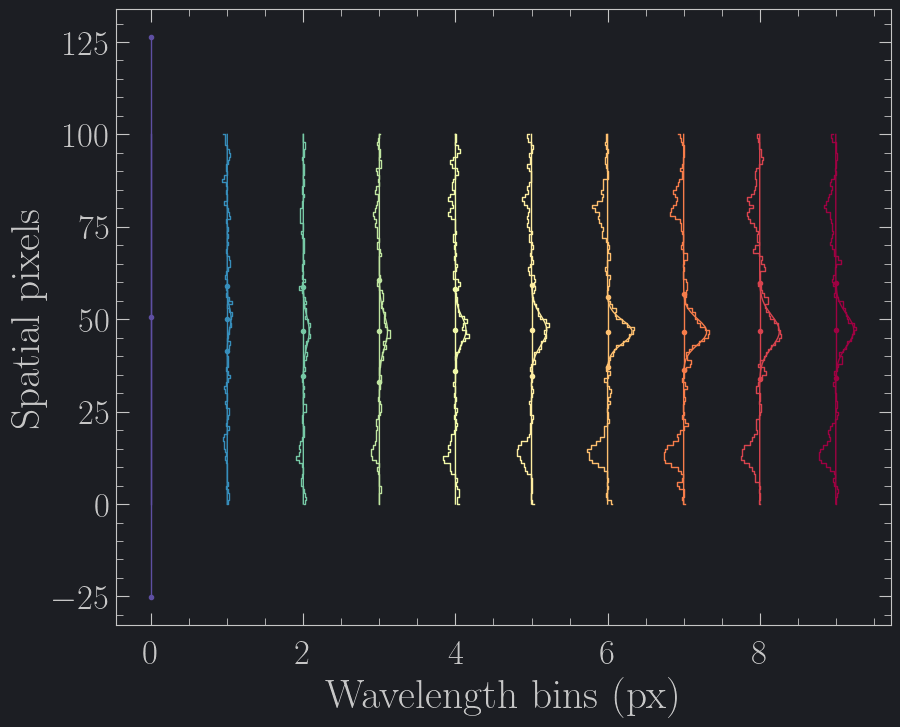

In [39]:
# Plot the fit
fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')

for i in range(n_bins):
    # Plot collapsed spectrum
    ax.plot(
        i+SNR_binned[:,i],
        spat_pixels,
        color=colors[i],
        drawstyle='steps-mid',
        lw=1,
    )

    sl = spat_collapsed_spec[f'{i}']
    ax.plot(
        i+sl['fit_model'](spat_pixels),
        spat_pixels,
        color=colors[i],
        lw=1,
    )
    ax.plot(
        [i,i,i],
        [fit_centers_px[i]-3*fit_widths_px[i], fit_centers_px[i], fit_centers_px[i]+3*fit_widths_px[i]],
        marker='o',
        markersize=3,
        lw=1,
        color=colors[i],
        )

ax.set_xlabel('Wavelength bins (px)')
ax.set_ylabel('Spatial pixels')
plt.show()

In [40]:
### Fit them as a function of pixels
polyn_deg = 2

fit_center_fit = Polynomial.fit(
    x=fit_rebinned_px,
    y=fit_centers_px,
    deg=polyn_deg,
)
fit_width_fit = Polynomial.fit(
    x=fit_rebinned_px,
    y=fit_widths_px,
    deg=polyn_deg,
)

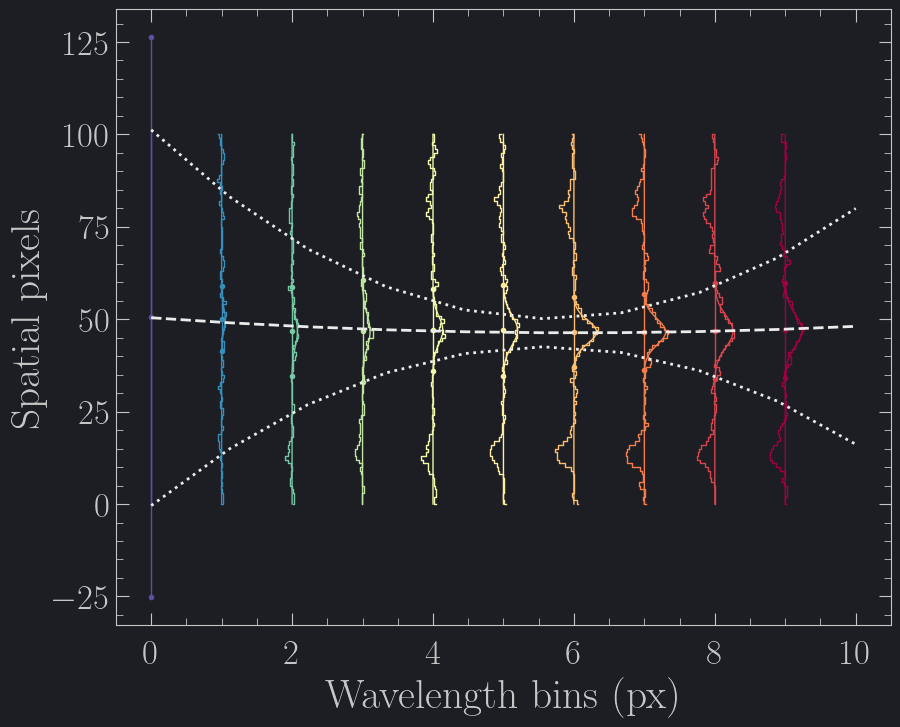

In [41]:
### Show the fit
# Do everything in pixel space

fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')


for i in range(n_bins):
    # Plot collapsed spectrum
    ax.plot(
        i+SNR_binned[:,i],
        spat_pixels,
        color=colors[i],
        drawstyle='steps-mid',
        lw=1,
    )

    sl = spat_collapsed_spec[f'{i}']
    ax.plot(
        i+sl['fit_model'](spat_pixels),
        spat_pixels,
        color=colors[i],
        lw=1,
    )
    ax.plot(
        [i,i,i],
        [fit_centers_px[i]-3*fit_widths_px[i], fit_centers_px[i], fit_centers_px[i]+3*fit_widths_px[i]],
        marker='o',
        markersize=3,
        lw=1,
        color=colors[i],
    )

x = np.linspace(0,n_bins,n_bins)
ax.plot(
    x,
    fit_center_fit(x),
    lw=2,
    ls='--',
    color='C12'
)
ax.plot(
    x,
    fit_center_fit(x)+3*fit_width_fit(x),
    lw=2,
    ls=':',
    color='C12'
)
ax.plot(
    x,
    fit_center_fit(x)-3*fit_width_fit(x),
    lw=2,
    ls=':',
    color='C12'
)

ax.set_xlabel('Wavelength bins (px)')
ax.set_ylabel('Spatial pixels')
plt.show()

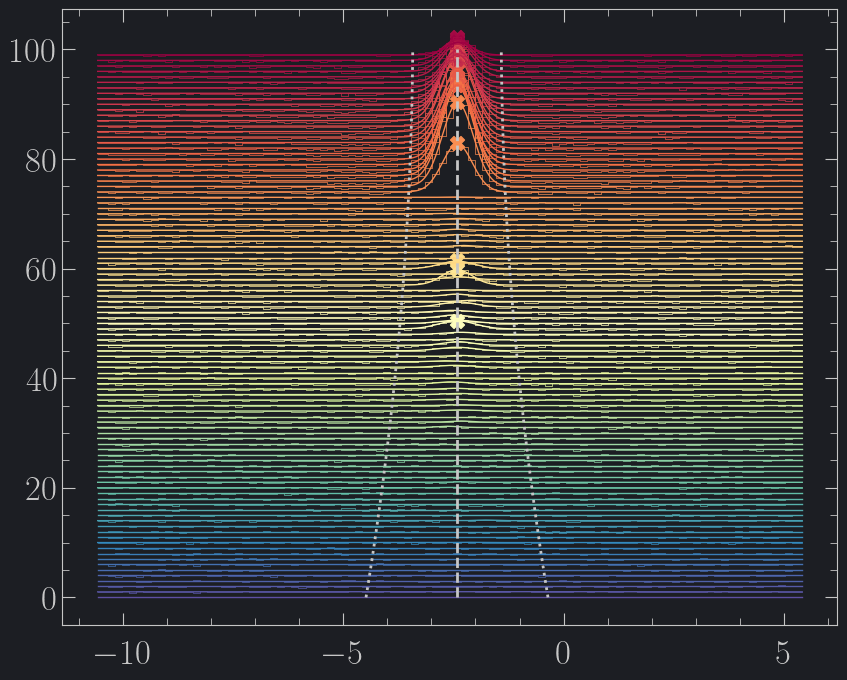

In [403]:
fig, ax = plt.subplots()
colors = cmr.take_cmap_colors('Spectral_r', n_bins, cmap_range=(0.0, 1), return_fmt='hex')


for i in range(n_bins):
    sl = spat_collapsed_spec[f'{i}']
    
    spat_high_res = np.linspace(spat.min(), spat.max(), 1000)
    ax.plot(
        spat,
        i+sl['flux'],
        color=colors[i],
        drawstyle='steps-mid',
        lw=0.5,
    )
    ax.plot(
        spat_high_res,
        i+sl['fit_model'](spat_high_res),
        color=colors[i],
        lw=1,
    )
    ax.scatter(
        spat[sl['peaks']],
        i+sl['flux'][sl['peaks']],
        marker='X',
        color=colors[i],
    )

x = np.linspace(0,n_bins,n_bins)
ax.plot(
    center_fit(x),
    x,
    lw=2,
    ls='--',
    color='C11'
)
ax.plot(
    center_fit(x)+3*width_fit(x),
    x,
    lw=2,
    ls=':',
    color='C11'
)
ax.plot(
    center_fit(x)-3*width_fit(x),
    x,
    lw=2,
    ls=':',
    color='C11'
)